# Analysis Workflow: Spectral Fitting

https://fermi.gsfc.nasa.gov/ssc/data/analysis/gbm/gbm_data_tools/gdt-docs/notebooks/SpectralFitting.html

In [4]:
from gbm import test_data_dir
from gbm.data import Cspec, GbmDetectorCollection

# Load some CSPEC files for a GRB
n0 = Cspec.open(test_data_dir+'/160509374/glg_cspec_n0_bn160509374_v01.pha')
n1 = Cspec.open(test_data_dir+'/160509374/glg_cspec_n1_bn160509374_v01.pha')
b0 = Cspec.open(test_data_dir+'/160509374/glg_cspec_b0_bn160509374_v01.pha')

# create a collection from the list of our files
cspecs = GbmDetectorCollection.from_list([n0, n1, b0])

In [1]:
# define some time and energy ranges
view_range = (-33.0, 102.0) # zoom in to this time range
bkgd_range = [(-550., -300.), (675., 1000.)] # the background fit ranges
src_range = (14.0, 17.0)    # our time selection
erange_nai = (8.0, 900.0) # in keV
erange_bgo = (325, 35000.0)

In [5]:
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

# initialize the fitters and add to collection, making sure the collection knows which background
# goes with which detector
backfitters = [BackgroundFitter.from_phaii(cspec, Polynomial, time_ranges=bkgd_range) for cspec in cspecs]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=cspecs.detector())

# do the fit
backfitters.fit(order=2)

# interpolate/extrapolate and store in a collection
bkgds = backfitters.interpolate_bins(cspecs.data()[0].tstart, cspecs.data()[0].tstop)
bkgds = GbmDetectorCollection.from_list(bkgds, dets=cspecs.detector())

In [6]:
# the lightcurves
data_lcs = cspecs.to_lightcurve(nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
# the source time selection
src_lcs = cspecs.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# the count spectrum
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection
src_specs = cspecs.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})


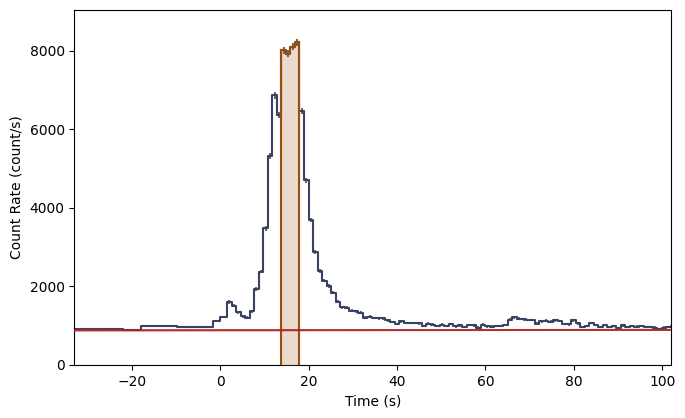

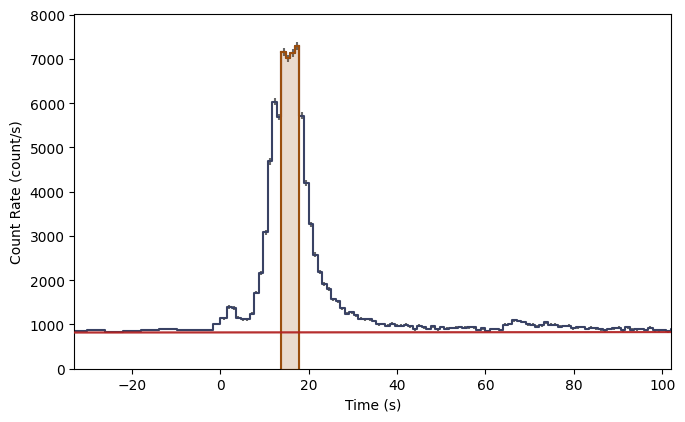

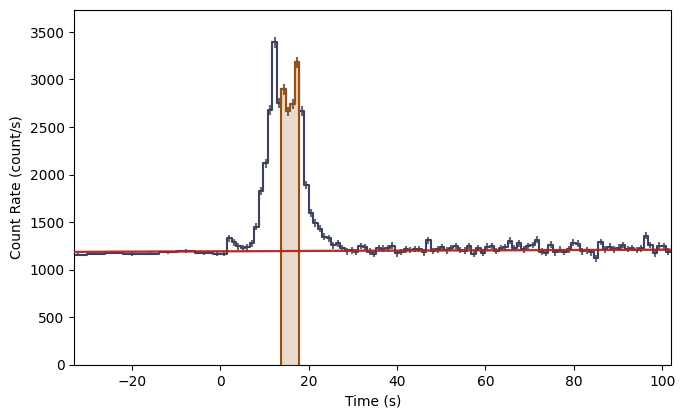

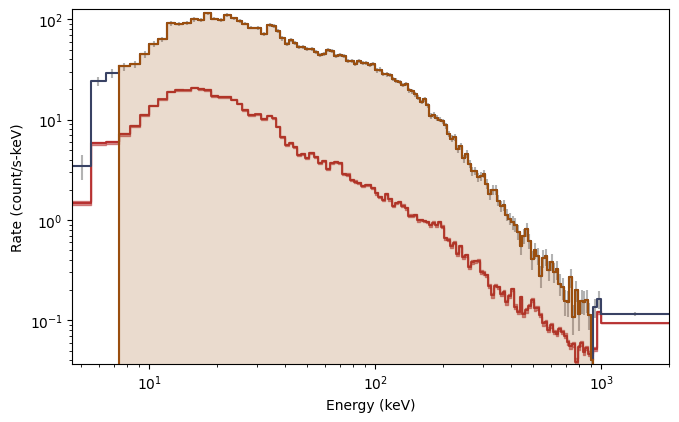

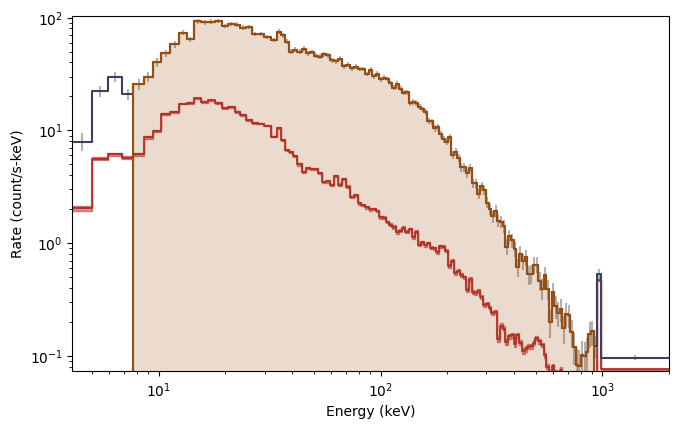

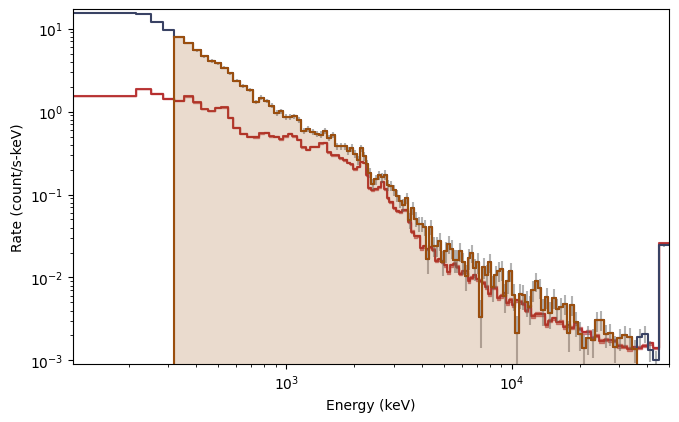

In [7]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

# Plot the lightcurves with the selections and background fit
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in
for lcplot in lcplots:
    lcplot.xlim = view_range

# Plot the spectra with the selections and background fit
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

In [8]:
from gbm.data import RSP
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':erange_nai}, bgo_kwargs={'energy_range':erange_bgo})

# open responses
rsp1 = RSP.open(test_data_dir+'/160509374/glg_cspec_n0_bn160509374_v00.rsp2')
rsp2 = RSP.open(test_data_dir+'/160509374/glg_cspec_n1_bn160509374_v00.rsp2')
rsp3 = RSP.open(test_data_dir+'/160509374/glg_cspec_b0_bn160509374_v00.rsp2')
rsps = GbmDetectorCollection.from_list([rsp1, rsp2, rsp3])

# and interpolate response files to get DRMs at center of the source window
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

In [9]:
from gbm.spectra.fitting import SpectralFitterPgstat

# we initialize with our PHAs, backgrounds, and responses:
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps.to_list(), method='TNC')

In [10]:
# a power law, cut-off power law, and a Band function
from gbm.spectra.functions import PowerLaw, Comptonized, Band

# instantiate a Band function
band = Band()

In [11]:
band.param_list

[('A', 'ph/s/cm^2/keV', 'Amplitude'),
 ('Epeak', 'keV', 'SED Peak'),
 ('alpha', '', 'Low-Energy Photon index'),
 ('beta', '', 'High-Energy Photon index'),
 ('Epiv', 'keV', 'Pivot energy')]

In [12]:
print(band.default_values)
print(band.min_values)
print(band.max_values)

[0.01, 500.0, -0.5, -2.5, 100.0]
[1e-10, 0.01, -1.9, -10.0, 0.01]
[inf, inf, 20.0, -2.0001, inf]


In [13]:
print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})

# After the fit has converged, we can query the fitter for lots of info, including the parameters that
# satisfy the maximum likelihood as well as the parameter uncertainties resulting from -2(Delta)LogLike
print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Band Fit:
Converged (|f_n-f_(n-1)| ~= 0)
Parameters: [ 3.07954074e-01  3.12820341e+02 -7.58290790e-01 -2.18948162e+00]
90% Asymm. Errors:
 [[3.77937090e-03 3.70349748e-03]
 [5.56342743e+00 5.54981919e+00]
 [1.54923870e-02 1.56258867e-02]
 [5.01353741e-02 4.52346802e-02]]
Pgstat/DoF: 277.3293010372007/358


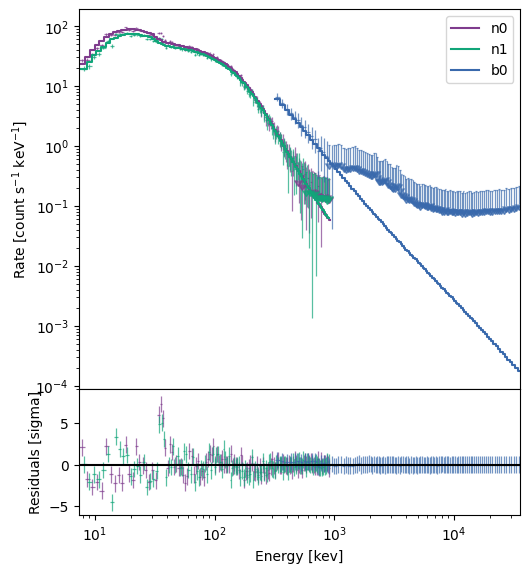

In [14]:
from gbm.plot import ModelFit

# initialize with your spectral fitter once the fit is done
modelplot = ModelFit(fitter=specfitter)

/home/karna/.pyenv/versions/3.6.15/lib/python3.6/site-packages/gbm/spectra/fitting.py:601: RuntimeWarning: covariance is not positive-semidefinite.
  **kwargs)


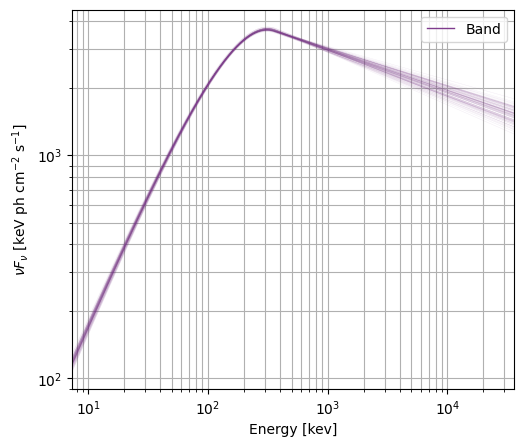

In [15]:
modelplot = ModelFit(fitter=specfitter, view='nufnu')
modelplot.ax.grid(which='both')

In [16]:
# flux over 10-1000 keV
photon_flux = band.integrate(specfitter.parameters, (10.0, 1000.0)) # photons/s/cm^2
energy_flux = band.integrate(specfitter.parameters, (10.0, 1000.0), energy=True) # erg/s/cm^2
photon_flux, energy_flux

(73.02643976894956, 1.4718574784791278e-05)

In [17]:
# we've defined a new model that is the sum of a Comptonized function and a power law
comp_pl = Comptonized() + PowerLaw()

# rerun the fit
print('Comp+PL Fit:')
specfitter.fit(comp_pl, options= {'maxiter': 1000})

print(specfitter.message)
print('Parameters: {}'.format(specfitter.parameters))
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Comp+PL Fit:
Linear search failed
Parameters: [ 2.54557379e-01  3.79886154e+02 -8.12210960e-01  1.27977217e-02
 -1.36137527e+00]
Pgstat/DoF: 352.50326573625347/357


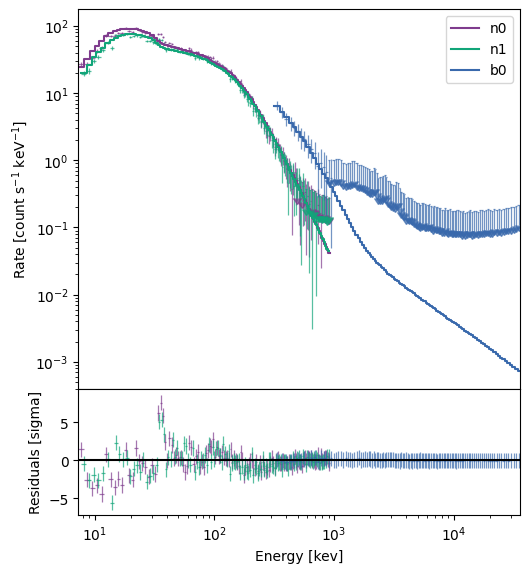

In [18]:
modelplot = ModelFit(fitter=specfitter)

/home/karna/.pyenv/versions/3.6.15/lib/python3.6/site-packages/gbm/spectra/fitting.py:601: RuntimeWarning: covariance is not positive-semidefinite.
  **kwargs)


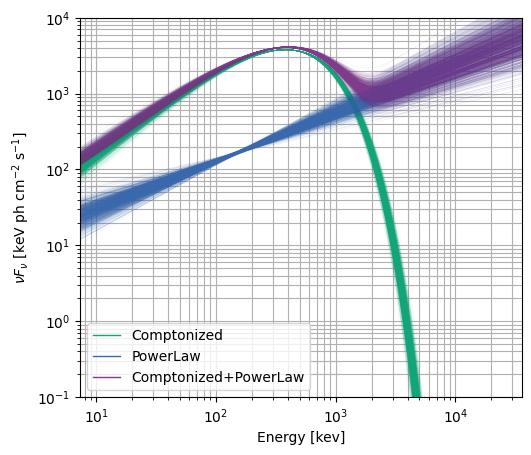

In [19]:
modelplot = ModelFit(fitter=specfitter)
# plot 1000 samples instead of the default 100
modelplot.nufnu_spectrum(num_samples=1000)
modelplot.ylim = (0.1, 10000.0)
modelplot.ax.grid(which='both')

In [20]:
specfitter.save('./my_second_fit.npz')